In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import datetime
import json
from pathlib import Path
from matplotlib import cm
import napari

sys.path.append("../complete_pipeline")
from utils import annotate_cropping_windows, crop_all_views, read_first_frame

In [6]:
if "BINDER_SERVICE_HOST" in os.environ:
    os.environ["DISPLAY"] = ":1.0"

In [22]:
transform_filters = {
    "mirror-top": "transpose=2,transpose=2,hflip",
    "mirror-bottom": "hflip",
    "mirror-left": "transpose=2,hflip",
    "mirror-right": "transpose=1,hflip",
    "central": "",  # No transformation
}


def get_coordinates(frame, name: str, coordinates):
    with napari.gui_qt():
        viewer = napari.Viewer()
    cmap = cm.get_cmap("hsv", len(coordinates[name]))
    colors = [cmap(i) for i in range(len(coordinates[name]))]

    viewer.add_image(frame, name=name, contrast_limits=[0, 255])
    points_layer = viewer.add_points(
        coordinates[name],
        size=10,
        face_color=colors,
        name="points",
        edge_color="white",
        edge_width=0.5,
    )
    points_layer.editable = True
    napari.run()
    adjusted_points = points_layer.data
    return adjusted_points


def hflip(arr, value):
    points_flipped = np.zeros_like(arr)  # initialize the array
    points_flipped[:, 1] = (
        np.asanyarray(value)[2] - arr[:, 1]
    )  # the new x is the width - the old x
    points_flipped[:, 0] = arr[:, 0]  # the y remains the same
    return points_flipped, np.asanyarray(value)


def transpose1(arr, value):
    points_transposed = np.zeros_like(arr)  # initialize the array
    points_transposed[:, 1] = (
        np.asanyarray(value)[3] - arr[:, 0]
    )  # the new x is the height - the old y
    points_transposed[:, 0] = arr[:, 1]  # the y remains the same
    value_tranps = np.array(
        [value[0], value[1], value[3], value[2]]
    )  # rotate the rectangle to follow transformation
    return points_transposed, value_tranps


def transpose2(arr, value):

    points_transposed = np.zeros_like(arr)  # initialize the array
    points_transposed[:, 1] = arr[:, 0]  # new x is the old y
    points_transposed[:, 0] = value[2] - arr[:, 1]  # new y is the width - the old x
    value_tranps = np.array(
        [value[0], value[1], value[3], value[2]]
    )  # change width and height to reflect the transformation
    return points_transposed, value_tranps


def no_transformation(arr, value):
    return arr, value


def transformation(key, coordinates_cropped, value):
    transform_filters = {
        "mirror-top": [transpose2, transpose2, hflip],
        "mirror-bottom": [hflip],
        "mirror-left": [transpose2, hflip],
        "mirror-right": [transpose1, hflip],
        "central": [no_transformation],
    }
    for f in transform_filters[key]:
        coordinates_cropped, value = f(coordinates_cropped, value)
    return coordinates_cropped

In [ ]:
def get_coordinates_arena_and_transform(rectangles, frame):
    """
    Function that allows you to adjust bounding boxes of the arena and get the coordinates for improve calibration

    -args: rectangles for cropping, frame to display the bounding boxes
    -returns: dictionary with the coordinates of the bounding boxes fo the arena transforrmed accordingly to the transformation applied to that point of view

    original coordinates are:
    """

    coordinates = np.load(
        r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\20240803\M4\140337\right_coords.pkl",
        allow_pickle=True,
    )

    coordinates_arena = {}

    for key, value in rectangles.items():
        coordinates_arena[key] = np.asanyarray(
            get_coordinates(frame, str(key), coordinates)
        )
        # cropping
        y, x, h, w = value  # try it first

        coordinates_arena[key][:, 1] = coordinates_arena[key][:, 1] - x
        coordinates_arena[key][:, 0] = coordinates_arena[key][:, 0] - y
        print(f"print cropped coordinates for {key} \n {coordinates_arena[key]}")

        # transform them
        coordinates_arena[key] = transformation(key, coordinates_arena[key], value)
    return coordinates_arena

In [9]:
video_path = r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\test_cropping\calibration_retest\Calibration\multicam_video_2024-08-03T16_36_58.avi"

In [10]:
first_frame = read_first_frame(video_path)

## get the coordinates for the uncropped video, display them over the original image before any transformation

In [16]:
coordinates = np.load(
    r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\20240803\M4\140337\right_coords.pkl",
    allow_pickle=True,
)

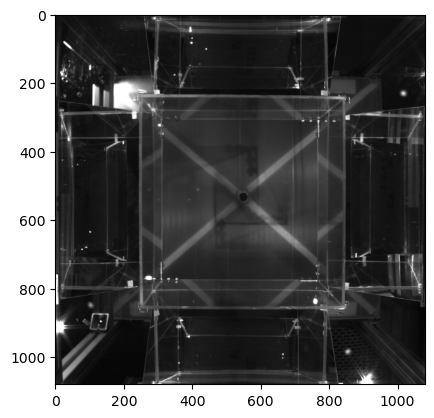

In [11]:
plt.imshow(first_frame)

In [27]:
views = ["central", "mirror-bottom", "mirror-left", "mirror-right", "mirror-top"]
arena_coordinates_uncropped = {}

In [28]:
for view in views:
    arena_coordinates_uncropped[view] = get_coordinates(first_frame, view, coordinates)

c:\Users\SNeurobiology\miniconda3\envs\lab-env\lib\contextlib.py:135: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  return next(self.gen)
C:\Users\SNeurobiology\AppData\Local\Temp\ipykernel_34720\2676776134.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("hsv", len(coordinates[name]))
C:\Users\SNeurobiology\AppData\Local\Temp\ipykernel_34720\2676776134.py:17: FutureWarning: Argument 'edg

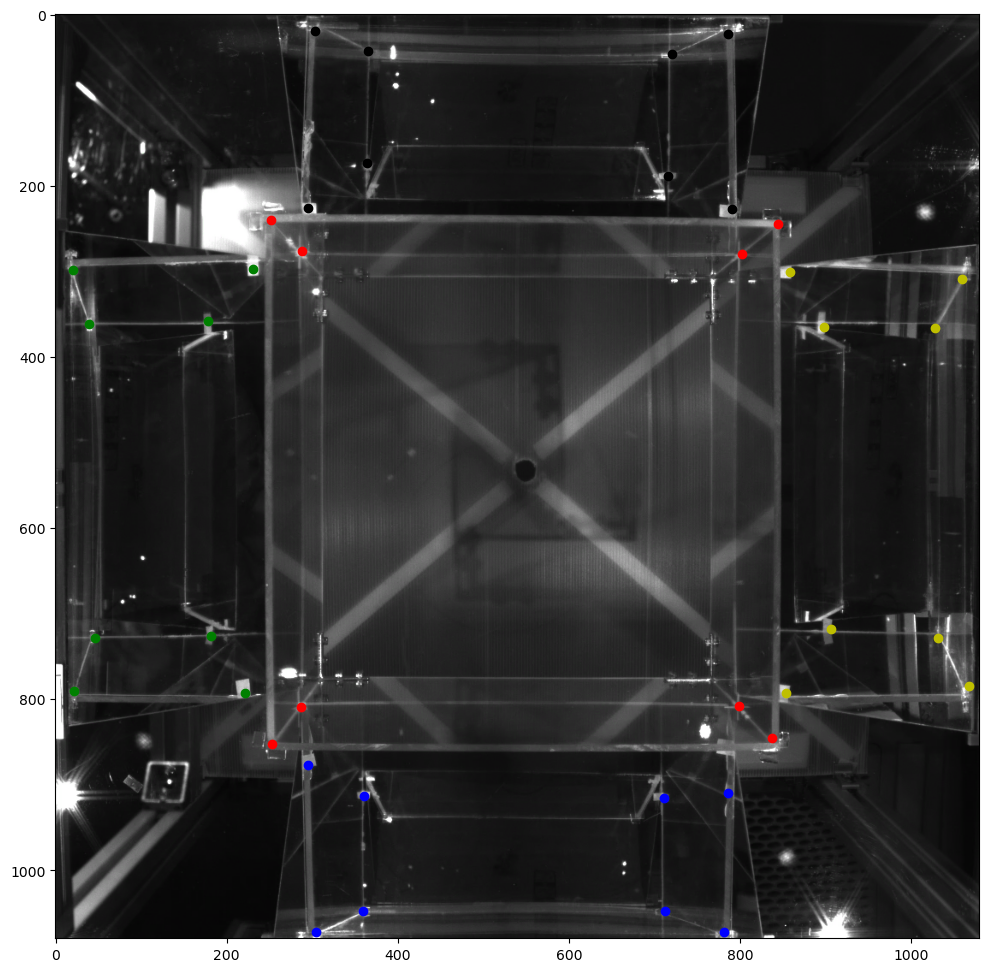

In [30]:
plt.figure(figsize=(16, 12))
plt.imshow(first_frame)

plt.scatter(
    arena_coordinates_uncropped["central"][:, 1],
    arena_coordinates_uncropped["central"][:, 0],
    c="r",
)

plt.scatter(
    arena_coordinates_uncropped["mirror-bottom"][:, 1],
    arena_coordinates_uncropped["mirror-bottom"][:, 0],
    c="b",
)

plt.scatter(
    arena_coordinates_uncropped["mirror-left"][:, 1],
    arena_coordinates_uncropped["mirror-left"][:, 0],
    c="g",
)

plt.scatter(
    arena_coordinates_uncropped["mirror-right"][:, 1],
    arena_coordinates_uncropped["mirror-right"][:, 0],
    c="y",
)

plt.scatter(
    arena_coordinates_uncropped["mirror-top"][:, 1],
    arena_coordinates_uncropped["mirror-top"][:, 0],
    c="k",
)

plt.show()

## Crop the video, transform each set of coordinates and dipslay them

### crop the image

In [53]:
rectangles = annotate_cropping_windows(first_frame)

In [58]:
cropped_frames = {}


for key, value in rectangles.items():
    value = np.array(value).astype(int)
    cropped_frames[key] = first_frame[
        value[0] : value[0] + value[3], value[1] : value[1] + value[2]
    ]

In [48]:
rectangles  # height_start, width_start, width, height

{'central': (238.0, 246.0, 608.0, 624.0),
 'mirror-top': (18.0, 246.0, 600.0, 220.0),
 'mirror-bottom': (858.0, 246.0, 608.0, 224.0),
 'mirror-left': (238.0, 28.0, 224.0, 624.0),
 'mirror-right': (238.0, 848.0, 224.0, 624.0)}

In [60]:
coordinates_arena = {}
for key, value in rectangles.items():

    coordinates_arena[key] = transformation(
        key, arena_coordinates_uncropped[key], value
    )

In [73]:
coordinates_arena

{'central': array([[239.87171421, 251.50775583],
        [244.52613441, 843.78272624],
        [844.94634017, 836.80109594],
        [851.92797047, 252.67136088],
        [276.66220958, 287.84494498],
        [280.20894296, 801.66855842],
        [807.59893819, 799.30208256],
        [808.94216404, 286.70027485]]),
 'mirror-top': array([[200.62830221, 302.87661533],
        [197.79663161, 786.14839764],
        [173.82303558, 720.20353711],
        [177.61157282, 365.3093835 ],
        [ -6.280088  , 294.52368539],
        [ -6.58726574, 790.31918882],
        [ 31.96278325, 715.37632567],
        [ 46.34405005, 364.2478856 ]]),
 'mirror-bottom': array([[1047.91295656,  248.56769756],
        [1047.69334235, -103.69721676],
        [1071.81092864, -173.00993148],
        [1072.19820742,  303.28696189],
        [ 913.39432791,  247.93490228],
        [ 915.91873389, -103.21428672],
        [ 909.4380279 , -178.32309504],
        [ 876.41762518,  312.64911886]]),
 'mirror-left': array([[

In [87]:
file = r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\test_cropping\calibration_retest\Calibration\multicam_video_2024-08-03T16_36_58_20241108-143350.json"

import json

with open(file) as f:
    d = json.load(f)
    print(d)
coordinates = d[-1]
coordinates_ars = {}

[{'transform': 'central', 'output_file_suffix': 'central.avi', 'filters': 'crop=608.0:624.0:246.0:238.0,format=gray', 'ffmpeg_args': {'-c:v': 'libx264', '-b:v': '30M', '-crf': '23', '-preset': 'superfast', '-pix_fmt': 'yuv420p', '-c:a': 'copy'}}, {'transform': 'mirror-top', 'output_file_suffix': 'mirror-top.avi', 'filters': 'crop=600.0:220.0:246.0:18.0,format=gray,transpose=2,transpose=2,hflip', 'ffmpeg_args': {'-c:v': 'libx264', '-b:v': '30M', '-crf': '23', '-preset': 'superfast', '-pix_fmt': 'yuv420p', '-c:a': 'copy'}}, {'transform': 'mirror-bottom', 'output_file_suffix': 'mirror-bottom.avi', 'filters': 'crop=608.0:224.0:246.0:858.0,format=gray,hflip', 'ffmpeg_args': {'-c:v': 'libx264', '-b:v': '30M', '-crf': '23', '-preset': 'superfast', '-pix_fmt': 'yuv420p', '-c:a': 'copy'}}, {'transform': 'mirror-left', 'output_file_suffix': 'mirror-left.avi', 'filters': 'crop=224.0:624.0:28.0:238.0,format=gray,transpose=2,hflip', 'ffmpeg_args': {'-c:v': 'libx264', '-b:v': '30M', '-crf': '23', '-

In [75]:
coordinates

{'points_coordinate': {'central': [[1.8717142122362702, 5.5077558337636106],
   [6.526134411887995, 597.7827262394451],
   [609.273550266786, 591.9647009898804],
   [613.9279704664376, 6.6713608836765275],
   [38.662209580421234, 41.84494497804775],
   [42.208942962058984, 555.6685584247004],
   [569.5989381911708, 553.3020825569407],
   [572.1057690947475, 40.70027485352381]],
  'mirror-top': [[218.62830220885579, 56.876615329947754],
   [215.7966316094108, 540.1483976352245],
   [191.82303558066482, 474.20353711184293],
   [195.61157282253583, 119.30938350418865],
   [11.719911995482079, 48.52368539228746],
   [11.412734258480555, 544.3191888218382],
   [52.289993351257465, 472.8671408160395],
   [64.34405004505658, 118.24788559800157]],
  'mirror-bottom': [[189.912956564222, 494.56769755941093],
   [189.69334235365477, 142.30278323518314],
   [213.81092863956383, 72.99006852182663],
   [214.19820741913122, 549.2869618908057],
   [54.230722861985214, 492.7712972258748],
   [57.918733

In [88]:
coordinates = coordinates["points_coordinate"]

In [96]:
img = read_first_frame(
    r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\test_cropping\calibration_retest\Calibration\multicam_video_2024-08-03T16_36_58_cropped_20241108143758\multicam_video_2024-08-03T16_36_58_central.avi.mp4"
)

TypeError: imshow() missing 1 required positional argument: 'X'

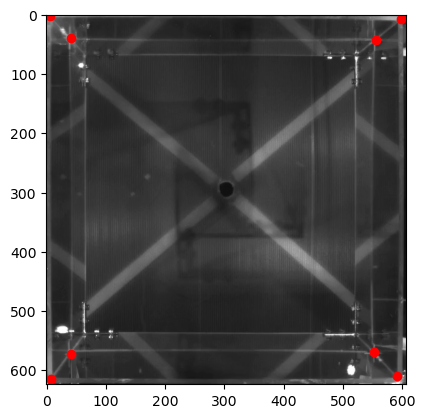

In [97]:
plt.imshow(img)
for i in coordinates["central"]:
    plt.scatter(i[1], i[0], c="r")
plt.imshow()

In [ ]:
input_file = r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\test_cropping\calibration_retest\Calibration\multicam_video_2024-08-03T16_36_58.avi"
input_file = Path(input_file)

tstamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

frame = read_first_frame(input_file)
rectangles = annotate_cropping_windows(frame)

# insert function to
coordinates_transfrmed = get_coordinates_arena_and_transform(rectangles, frame)


test_output_dir = input_file.parent / f"test-output_{tstamp}"

cropping_specs = []

## get mouse skeleton manually to test calibration

In [10]:
video_paths = []
dir = Path(
    r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\test_cropping\sample\multicam_video_2024-07-24T10_04_55_cropped_20241104101620"
)
for file in dir.iterdir():
    if file.suffix == ".mp4" and "processed" not in file.name:
        video_paths.append(file)

In [11]:
video_paths

[WindowsPath('D:/P05_3DRIG_YE-LP/e01_mouse_hunting/v04_mice-hunting/test_cropping/sample/multicam_video_2024-07-24T10_04_55_cropped_20241104101620/multicam_video_2024-07-24T10_04_55_central.avi.mp4'),
 WindowsPath('D:/P05_3DRIG_YE-LP/e01_mouse_hunting/v04_mice-hunting/test_cropping/sample/multicam_video_2024-07-24T10_04_55_cropped_20241104101620/multicam_video_2024-07-24T10_04_55_mirror-bottom.avi.mp4'),
 WindowsPath('D:/P05_3DRIG_YE-LP/e01_mouse_hunting/v04_mice-hunting/test_cropping/sample/multicam_video_2024-07-24T10_04_55_cropped_20241104101620/multicam_video_2024-07-24T10_04_55_mirror-left.avi.mp4'),
 WindowsPath('D:/P05_3DRIG_YE-LP/e01_mouse_hunting/v04_mice-hunting/test_cropping/sample/multicam_video_2024-07-24T10_04_55_cropped_20241104101620/multicam_video_2024-07-24T10_04_55_mirror-right.avi.mp4'),
 WindowsPath('D:/P05_3DRIG_YE-LP/e01_mouse_hunting/v04_mice-hunting/test_cropping/sample/multicam_video_2024-07-24T10_04_55_cropped_20241104101620/multicam_video_2024-07-24T10_04_55

In [12]:
# get the same frame from all videos:
idx = 18966

import cv2

cap = cv2.VideoCapture(str(video_paths[0]))
cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
res, frame = cap.read()

In [14]:
frames = []
for frame in video_paths:
    cap = cv2.VideoCapture(str(frame))
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    res, frame = cap.read()
    frames.append(frame)

In [24]:
def skeletons(frame, name: str):
    with napari.gui_qt():
        viewer = napari.Viewer()
    points = []

    viewer.add_image(frame, name=name, contrast_limits=[0, 255])
    points_layer = viewer.add_points(
        [],
        name="points",
        edge_color="white",
        edge_width=0.5,
    )

    def save_points(events):
        nonlocal points
        points = points_layer.data.copy()
        return points

    viewer.events.connect(save_points)
    points_layer.editable = True
    napari.run()
    return points

In [ ]:
skeleton_mouse = {}
names = ["central", "mirror-bottom", "mirror-left", "mirror-right", "mirror-top"]

In [25]:
skeletons(frames[0], "central")

c:\Users\SNeurobiology\miniconda3\envs\lab-env\lib\contextlib.py:135: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  return next(self.gen)
C:\Users\SNeurobiology\AppData\Local\Temp\ipykernel_41556\3678120512.py:7: FutureWarning: Argument 'edge_width' is deprecated, please use 'border_width' instead. The argument 'edge_width' was deprecated in 0.5.0 and it will be removed in 0.6.0.
  points_layer = viewer.add_points([],
c:\Users\SNeurobiology\miniconda3\envs\lab-env\lib\site-packages\napari\utils\migrations.py:101: FutureWarning: Argument 'edge_color' is deprecated, please use 'bord

[]